# Make a centered model of the HLC PSF 

In [1]:
import numpy as np
from astropy.io import fits
import numpy as np
import astropy.units as u
import astropy.constants as const
import os

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

plt.style.use('dark_background')

import scipy.ndimage.interpolation
import scipy.signal
import skimage.transform
import exoscene.image

In [2]:
cal_data_dir = os.path.relpath("../../Data/official2019/HLC/HLC CAL/")
analysis_results_dir = os.path.relpath("./results/")

### Load HLC PSF model files

In [3]:
os.listdir(cal_data_dir)

['OS6_HLC_PSFs_offset.fits',
 'OS6_HLC_PSFs_fine_offset_list.fits',
 'unocc_star_psf.png',
 'OS6_HLC_PSFs_fine_offset.fits',
 'OS6_HLC_PSF_peak_map.fits',
 'HLC_scistar_unocc_PSF_model.fits',
 'OS6_HLC_PSFs_offset_list.fits',
 'hlc_psf_peak_map.png']

In [4]:
offset_psfs_fname = os.path.join(cal_data_dir, 'OS6_HLC_PSFs_offset.fits')
offset_psfs_offsets_fname = os.path.join(cal_data_dir, 'OS6_HLC_PSFs_offset_list.fits')

In [5]:
cx_os6 = 100 # True center of the high-res OS6 array,
             # derived from checking the peak-offset correspondence in the off-axis PSF model. 
pixscale_as = (fits.getheader(offset_psfs_fname))['PIX_AS']
pixscale_LoD = (fits.getheader(offset_psfs_fname))['PIXSCALE']

print(pixscale_as)
print(pixscale_LoD)

0.00501914
0.1


In [6]:
offset_psfs_os6 = fits.getdata(offset_psfs_fname)
offsets_LoD = fits.getdata(offset_psfs_offsets_fname)
offsets_as = offsets_LoD * pixscale_as / pixscale_LoD

print(offset_psfs_os6.shape)
print(offsets_LoD.shape)
print(offsets_LoD)

(17, 200, 200)
(17,)
[0.89999998 2.0999999  2.4000001  2.70000005 3.29999995 3.5999999
 3.9000001  4.5        4.80000019 5.4000001  6.         7.19999981
 8.10000038 8.39999962 8.69999981 9.         9.30000019]


### Apply half-pixel shift to OS6 arrays to place center at (99.5, 99.5)

In [7]:
offset_psfs = scipy.ndimage.interpolation.shift(offset_psfs_os6, (0, -0.5, -0.5),
                                                order = 1, prefilter=False,
                                                mode = 'constant', cval=0)
offset_psfs.shape

(17, 200, 200)

In [8]:
r_p = 60 # offset PSF position with relatively little distortion from FPM or field stop
print("Using PSF model with angular separation {:.2f} lam/D".format(r_p * pixscale_LoD))
theta = 0 # destination theta
r_as = r_p * pixscale_as
oi = np.argmin(np.abs(r_as - offsets_as)) # index of closest radial offset in Krist model array
dr_as = r_as - offsets_as[oi] # radial shift needed in arcseconds
dr_p = dr_as / pixscale_as # radial shift needed in pixels

shift_psf = scipy.ndimage.interpolation.shift(offset_psfs[oi], (0, dr_p),
                                              order = 1, prefilter=False)

cent_shift_psf = np.roll(shift_psf, -r_p, axis=1)

Using PSF model with angular separation 6.00 lam/D


In [9]:
cent_shift_psf.shape

(200, 200)

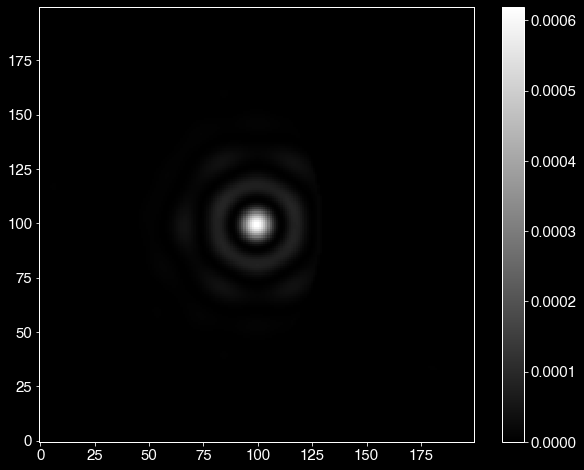

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(cent_shift_psf)
plt.colorbar()

In [11]:
cent_psf_fname = os.path.join(analysis_results_dir, 'hlc_centered_psf.fits')
if not os.path.exists(cent_psf_fname):
    fits.writeto(cent_psf_fname, cent_shift_psf)